# k-means

教師なしのクラスタリング

・各点$x_{i}$に対してランダムにクラスタを割り当てる。  
・収束するまで以下を繰り返す。
1. 各クラスタに割り当てられた点について重心を計算する。
2. 各点について、上記で計算された重心からの距離を計算し、距離が一番近いクラスタに割り当て直す。  
収束条件は,点のクラスタへの所属情報が変化しない場合または所属情報の変化が一定の割合以下である場合。

距離としては、一般的にユークリッド距離を使う。

j番目のクラスタに属する点のインデックス集合を$I_{j}$とするとクラスタ重心は  
$$
        G_{j} = \frac{1}{|I_{j}|}\sum_{i \in I_{j}}\boldsymbol{x}_{i}
$$

各クラスタの重心を求める上での実装上の工夫

特徴量行列Xと各点(レコード)のラベルlabels

In [2]:
import numpy as np
X = np.array([[1,2]
             ,[2,3]
             ,[3,4]
             ,[4,5]
             ,[5,6]
             ,[6,7]
             ,[7,8]])
labels = np.array([0,1,2,0,1,2,0])

0に所属→(1,2), (4,5), (7,8)  
1に所属→(2,3), (5,6)  
2に所属→(3,4), (6,7)

工夫：クラスタ0に所属するデータ点のみ抽出する

In [3]:
X[labels==0,:]

array([[1, 2],
       [4, 5],
       [7, 8]])

重心を計算するには、縦方向に平均を取れば良い

In [4]:
X[labels==0,:].mean(axis=0)

array([4., 5.])

クラスタの中心cluster_centers

In [5]:
cluster_centers = np.array([[1,1]
                           ,[2,2]
                           ,[3,3]])

3つの中心とX(特徴量行列)で表される7つの店との距離を総当たりで計算する必要があるが、距離の２乗は下記の方法で一気に計算できる。

In [6]:
X[:,:]

array([[1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6],
       [6, 7],
       [7, 8]])

In [7]:
X[:,:,np.newaxis]

array([[[1],
        [2]],

       [[2],
        [3]],

       [[3],
        [4]],

       [[4],
        [5]],

       [[5],
        [6]],

       [[6],
        [7]],

       [[7],
        [8]]])

In [8]:
cluster_centers.T

array([[1, 2, 3],
       [1, 2, 3]])

In [9]:
cluster_centers.T[np.newaxis,:,:]

array([[[1, 2, 3],
        [1, 2, 3]]])

In [10]:
X[:,:,np.newaxis] - cluster_centers.T[np.newaxis,:,:]

array([[[ 0, -1, -2],
        [ 1,  0, -1]],

       [[ 1,  0, -1],
        [ 2,  1,  0]],

       [[ 2,  1,  0],
        [ 3,  2,  1]],

       [[ 3,  2,  1],
        [ 4,  3,  2]],

       [[ 4,  3,  2],
        [ 5,  4,  3]],

       [[ 5,  4,  3],
        [ 6,  5,  4]],

       [[ 6,  5,  4],
        [ 7,  6,  5]]])

In [11]:
(X[:,:,np.newaxis] - cluster_centers.T[np.newaxis,:,:])**2

array([[[ 0,  1,  4],
        [ 1,  0,  1]],

       [[ 1,  0,  1],
        [ 4,  1,  0]],

       [[ 4,  1,  0],
        [ 9,  4,  1]],

       [[ 9,  4,  1],
        [16,  9,  4]],

       [[16,  9,  4],
        [25, 16,  9]],

       [[25, 16,  9],
        [36, 25, 16]],

       [[36, 25, 16],
        [49, 36, 25]]])

In [13]:
s = ((X[:,:,np.newaxis] - cluster_centers.T[np.newaxis,:,:])**2).sum(axis=1)
s

array([[ 1,  1,  5],
       [ 5,  1,  1],
       [13,  5,  1],
       [25, 13,  5],
       [41, 25, 13],
       [61, 41, 25],
       [85, 61, 41]])

データ点(レコード)に最も近い所属クラスタはaxis=1方向に距離が短いもの

In [14]:
s.argmin(axis=1)

array([0, 1, 2, 2, 2, 2, 2])

実装

In [26]:
import numpy as np
import itertools

class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters_ = n_clusters
        self.max_iter_ = max_iter
        self.random_state_ = np.random.RandomState(random_seed)
        
    def fit(self, X):
        # 初期値として各レコード(データ点)に対応するクラスタを決める
        cycle = itertools.cycle(range(self.n_clusters_)) # 0~self.n_clusters-1のサイクリックなジェネレーターを作る
        self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
        
        # 準備
        self.random_state_.shuffle(self.labels_)
        self.labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters_, X.shape[1]))
        
        # イテレーション
        while (not (self.labels_ == self.labels_prev).all() and count < self.max_iter_):
            for i in range(self.n_clusters_):
                XX = X[self.labels_ == i,:]
                self.cluster_centers_[i,:] = XX.mean(axis=0)
                dist = ((X[:,:,np.newaxis] - self.cluster_centers_.T[np.newaxis,:,:])**2).sum(axis=1)
                self.labels_prev = self.labels_
                self.labels_ = dist.argmin(axis=1)
                count += 1
                
    def predict(self, X):
        dist = ((X[:,:,np.newaxis] - self.cluster_centers_.T[np.newaxis,:,:])**2).sum(axis=1)
        labels = dist.argmin(axis=1)
        return labels
                

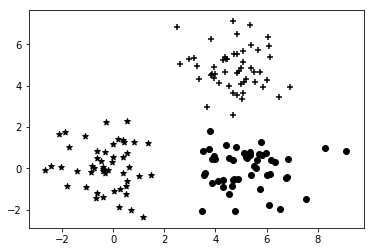

In [30]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)
points1 = np.random.randn(50, 2)
points2 = np.random.randn(50, 2) + np.array([5, 0])
points3 = np.random.randn(50, 2) + np.array([5, 5])

points = np.r_[points1, points2, points3]
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

markers = ['+', '*', 'o']
for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], color='k', marker=markers[i])
plt.show()

### scikit-learn k-means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans